In [1]:
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms


In [2]:
# You can download the data at https://github.com/zalandoresearch/fashion-mnist

In [3]:
img_size = 64
n_epochs = 24
batch_size = 64
learning_rate = 0.0002

In [4]:
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('Data/fashion', train=True, download=False, transform=transform),
    batch_size=batch_size, shuffle=True)

In [10]:
class discriminator_model(nn.Module):
    def __init__(self):
        super(discriminator_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x

In [11]:
def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()

In [12]:
class generator_model(nn.Module):
    def __init__(self):
        super(generator_model, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, 1024, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x

In [30]:
def plot_output():
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile=True)

    generator.eval()
    test_images = generator(z_)
    generator.train()

    grid_size = 5
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
    for i, j in itertools.product(range(grid_size), range(grid_size)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    for k in range(grid_size*grid_size):
        i = k // grid_size
        j = k % grid_size
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    plt.show()

In [22]:
generator = generator_model()
discriminator = discriminator_model()
generator.weight_init()
discriminator.weight_init()

In [23]:
generator.cuda()
discriminator.cuda()

discriminator_model (
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [24]:
BCE_loss = nn.BCELoss()

In [25]:
beta_1 = 0.5
beta_2 = 0.999
G_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
D_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate/2, betas=(beta_1, beta_2))

Epoch 1 - loss_d: 0.435, loss_g: 3.245


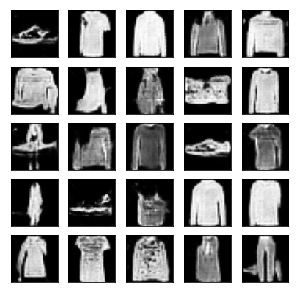

Epoch 2 - loss_d: 0.358, loss_g: 3.518


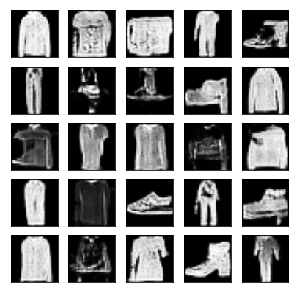

Epoch 3 - loss_d: 0.401, loss_g: 3.667


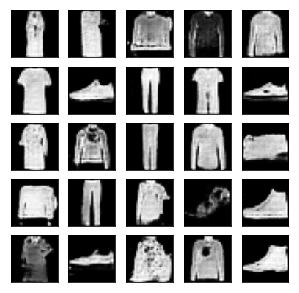

Epoch 4 - loss_d: 0.281, loss_g: 3.819


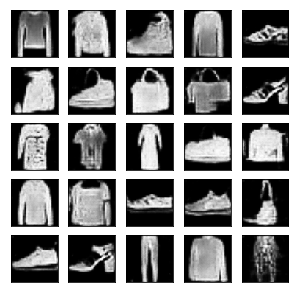

Epoch 5 - loss_d: 0.294, loss_g: 4.087


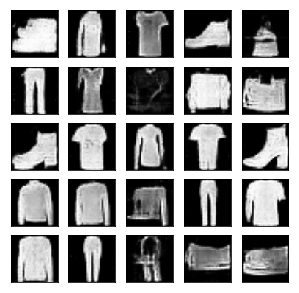

Epoch 6 - loss_d: 0.276, loss_g: 4.181


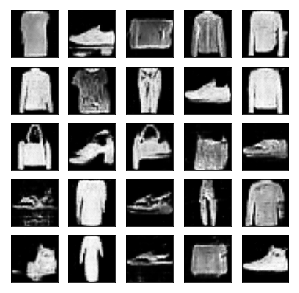

Epoch 7 - loss_d: 0.273, loss_g: 4.248


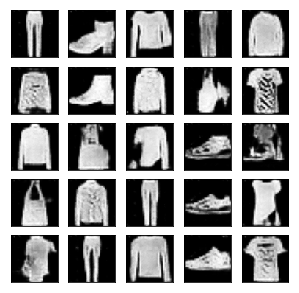

Epoch 8 - loss_d: 0.403, loss_g: 4.021


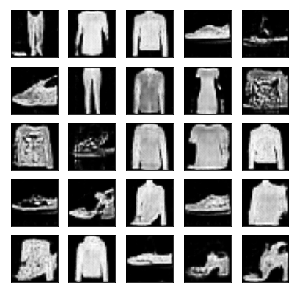

Epoch 9 - loss_d: 0.204, loss_g: 4.530


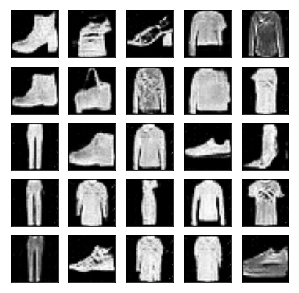

Epoch 10 - loss_d: 0.237, loss_g: 4.507


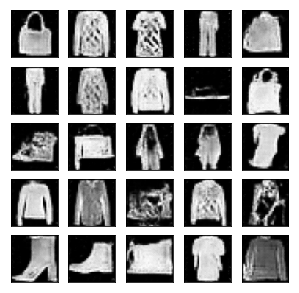

Epoch 11 - loss_d: 0.273, loss_g: 4.644


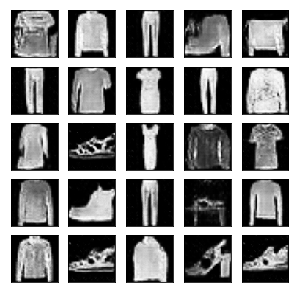

Epoch 12 - loss_d: 0.355, loss_g: 4.293


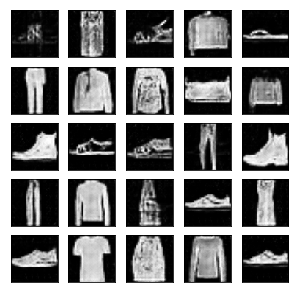

Epoch 13 - loss_d: 0.264, loss_g: 4.340


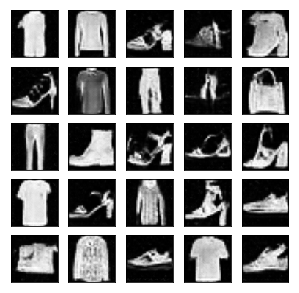

Epoch 14 - loss_d: 0.248, loss_g: 4.543


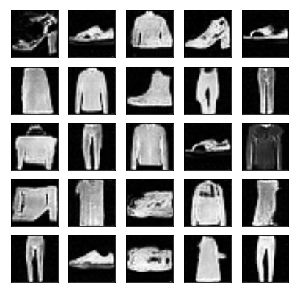

Epoch 15 - loss_d: 0.272, loss_g: 4.494


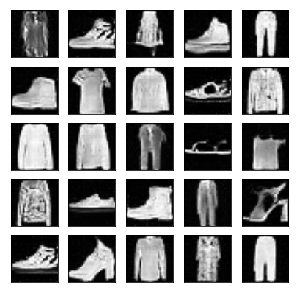

Epoch 16 - loss_d: 0.261, loss_g: 4.525


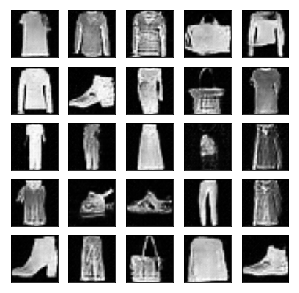

Epoch 17 - loss_d: 0.287, loss_g: 4.223


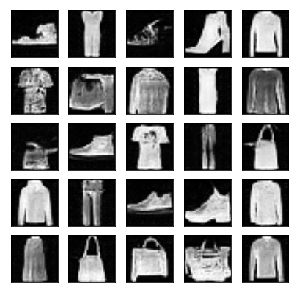

Epoch 18 - loss_d: 0.266, loss_g: 4.380


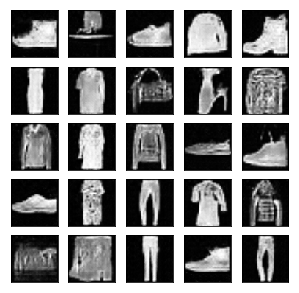

Epoch 19 - loss_d: 0.146, loss_g: 5.351


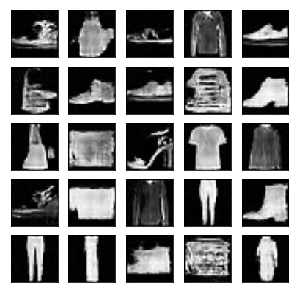

Epoch 20 - loss_d: 0.287, loss_g: 4.543


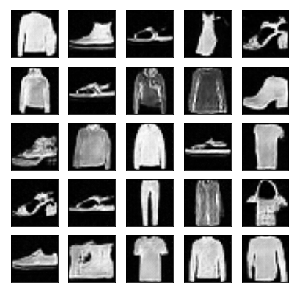

Epoch 21 - loss_d: 0.236, loss_g: 4.601


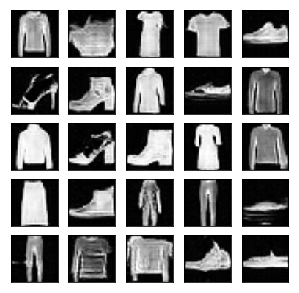

Epoch 22 - loss_d: 0.215, loss_g: 4.810


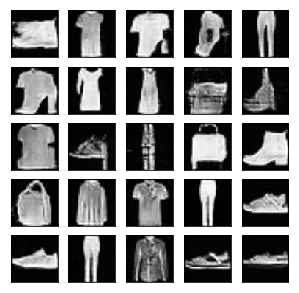

Epoch 23 - loss_d: 0.205, loss_g: 4.877


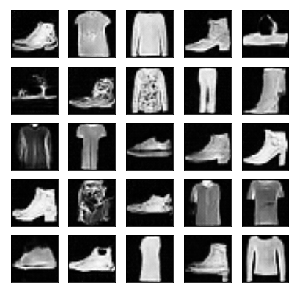

Epoch 24 - loss_d: 0.298, loss_g: 4.470


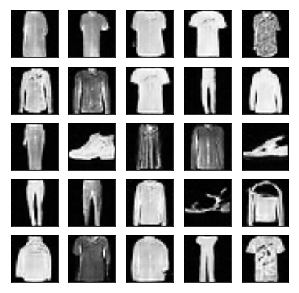

In [32]:
for epoch in range(n_epochs):
    D_losses = []
    G_losses = []
    for X, _ in train_loader:
        discriminator.zero_grad()
        mini_batch = X.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        X = Variable(X.cuda())
        y_real_ = Variable(y_real_.cuda())
        y_fake_ = Variable(y_fake_.cuda())
                
        D_result = discriminator(X).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        G_result = generator(z_)

        D_result = discriminator(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()
        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()     
        D_losses.append(D_train_loss.data[0]) 
        generator.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = generator(z_)
        D_result = discriminator(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss.data[0])

    print('Epoch {} - loss_d: {:.3f}, loss_g: {:.3f}'.format((epoch + 1), torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))    
    plot_output()